Here, I test whether my LSTM net works or not to estimate SGM parameters 

Now I run the real data from Parul (Apr 2, 2023)

In [1]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import trange, tqdm
import time

plt.style.use(FIG_ROOT/"base.mplstyle")
%matplotlib inline

In [3]:
import importlib
import models.lstm
importlib.reload(models.lstm)

<module 'models.lstm' from '/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/models/lstm.py'>

In [4]:
from utils.reparam import theta2raw_torch, raw2theta_torch, raw2theta_np
from spectrome import Brain
from sgm.sgm_fixed import SGM
from utils.misc import save_pkl, save_pkl_dict2folder, load_pkl, load_pkl_folder2dict, delta_time
from models.lstm import LSTM_SGM
from utils.standardize import std_mat, std_vec

In [5]:
# pkgs for pytorch ( Mar 27, 2023) 
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR

torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    torch.cuda.set_device(2)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    torch.backends.cudnn.benchmark = True
else:
    torch.set_default_tensor_type(torch.DoubleTensor)

## Data, fn and paras

In [6]:
import netCDF4
fils = list(DATA_ROOT.glob("*s100tp.nc"))
file2read = netCDF4.Dataset(fils[0], 'r')
psd_all = np.array(file2read.variables["__xarray_dataarray_variable__"][:])
time_points = np.array(file2read.variables["timepoints"][:])
freqs = np.array(file2read.variables["frequencies"][:])
ROIs_order = np.array(file2read.variables["regionx"][:])
file2read.close()

In [7]:
# Load the Connectome
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

In [8]:
# some constant parameters for this file
paras = edict()

## I reorder them in an alphabetical order and I change tauC to tauG (Mar 27, 2023)
## the orginal order is taue, taui, tauC, speed, alpha, gii, gei
## paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
## paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
##

# alpha, gei, gii, taue, tauG, taui, speed 
paras.par_low = np.array([0.1, 0.001,0.001, 0.005, 0.005, 0.005, 5])
paras.par_high = np.asarray([1, 0.7, 2, 0.03, 0.03, 0.20, 20])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = ["alpha", "gei", "gii", "Taue", "TauG", "Taui", "Speed"]

paras.C = brain.reducedConnectome
paras.D = brain.distance_matrix
paras.freqs = freqs

In [9]:
# running parameters
# May change

paras_run = edict()

paras_run.n = 1000
# note k can differ from SGM_net
paras_run.k = 1.0 # the parameter for reparameterization in logistic
paras_run.sd = 10 # The std to generate SGM parameters in raw scale (R)

## Train the model

In [10]:
from torch.utils.data import DataLoader, Dataset
_theta2raw = lambda Y: theta2raw_torch(Y, paras.prior_bds, paras_run.k)

In [11]:
trained_model = load_pkl_folder2dict(RES_ROOT/"SGM_net", excluding=['opt*'])
sgm_net = trained_model.model

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/freqs.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/loss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/loss_test.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/paras.pkl


In [12]:
# functions to generate training sample (Apr 1, 2023)
def random_choice(n, batchsize=1, len_seg=None):
    """Randomly select the lower and upper bound of the segment
        args:
            n: len of the total time series
    """
    if len_seg is None:
        len_seg = torch.randint(low=10, high=100, size=(1, ))
    up_bd = torch.randint(low=len_seg.item(), high=n, size=(batchsize, ))
    low_bd = up_bd - len_seg
    return low_bd, up_bd


def random_samples_rnn(X, Y=None, batchsize=1, 
                       bds=None, 
                       is_std=True, 
                       theta2raw_fn=None):
    """Randomly select a sample from the whole segment
        args:
            X: PSD, num x 68 x nfreq
            Y: params, num x 7, in orignal sgm scale
        return:
            X_seqs: len_seq x batchsize x num_fs
            Y_seqs: len_seq x batchsize x 7
            
    """
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X)
    if is_std:
        #X = X/X.std(axis=(1, 2), keepdims=True)
        # Let std for each ROI and each data
        X = (X-X.mean(axis=2, keepdims=True))/X.std(axis=2, keepdims=True)
    if Y is not None:
        if not isinstance(Y, torch.Tensor):
            Y = torch.tensor(Y)
        if theta2raw_fn: 
            Y = theta2raw_fn(Y)
    if bds is None:
        low_bds, up_bds = random_choice(len(X), batchsize)
    else:
        low_bds, up_bds = bds

    X = X.flatten(1)
    X_seqs = []
    Y_seqs = []
    for low_bd, up_bd in zip(low_bds, up_bds):
        X_seq = X[low_bd:up_bd, :].unsqueeze(1)
        X_seqs.append(X_seq)
        if Y is not None:
            Y_seq = Y[low_bd:up_bd].unsqueeze(1)
            Y_seqs.append(Y_seq)
    if Y is not None:
        return torch.cat(X_seqs, dim=1), torch.cat(Y_seqs, dim=1)
    else:
        return torch.cat(X_seqs, dim=1)
        

In [13]:
def weighted_mse_loss(pred, target, ws=None):
    """
    Calculates the weighted mean squared error loss between predicted and target values.

    Args:
        pred (torch.Tensor): predicted values
        target (torch.Tensor): target values
        ws (torch.Tensor, optional): weights for each value. Defaults to None.

    Returns:
        torch.Tensor: weighted mean squared error loss
    """
    if ws is None:
        ws = torch.ones_like(pred[0])
        ws[:, :20] = ws[:, :20]*10
    return torch.mean((pred-target)**2 * ws)

In [99]:
def cos_simi_loss(input_, target):
    """
    Calculates the cosine similarity loss between the input and target tensors.
    
    Args:
    input_ (torch.Tensor): The input tensor.
    target (torch.Tensor): The target tensor.
    
    Returns:
    torch.Tensor: The negative mean of the cosine similarity loss.
    """
    fn = nn.CosineSimilarity(dim=-1)
    losses = fn(input_, target)
    return - losses.mean()

In [115]:
paras_rnn = edict()
paras_rnn.batchsize = 64
paras_rnn.niter = 500
paras_rnn.loss_out = 5
paras_rnn.clip = 1 # from 
paras_rnn.lr_step = 200

paras_rnn.k = 1
paras_rnn.hidden_dim = 1024
paras_rnn.output_dim = 7
paras_rnn.input_dim = 68*len(paras.freqs)
paras_rnn.is_bidirectional = False

In [158]:
#  real data, should be len_seq x nrois x nfreqs
data_idx = 1
cur_data = psd_all[:, :, :, 1].transpose(2, 0, 1)

In [159]:
rnn = LSTM_SGM(input_dim=paras_rnn.input_dim, 
               hidden_dim=paras_rnn.hidden_dim, 
               output_dim=paras_rnn.output_dim, 
               is_bidirectional=paras_rnn.is_bidirectional, 
               prior_bds=torch.tensor(paras.prior_bds), 
               k = paras_rnn.k
)
loss_fn = nn.MSELoss()
loss_fn = weighted_mse_loss
loss_fn = cos_simi_loss

optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-4, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=0.3, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-04.


In [160]:
# training
loss_cur = 0
losses = []
losses_test = []

t0 = time.time()
sgm_net.eval()
for ix in range(paras_rnn.niter):
    X_seq = random_samples_rnn(cur_data, 
                                  batchsize=paras_rnn.batchsize, 
                                  theta2raw_fn=_theta2raw)
    # Zero the gradients
    optimizer.zero_grad()
    
    theta_pred = rnn(X_seq)
    X_pred = sgm_net(theta_pred.flatten(0, 1))
    loss = loss_fn(X_seq.flatten(0, 1).reshape(-1, 68, len(paras.freqs)),
                   X_pred)
    
    # Perform backward pass
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), paras_rnn.clip)
    # Perform optimization
    optimizer.step()
    
    loss_cur = loss_cur + loss.item()
    if ix % paras_rnn.loss_out == (paras_rnn.loss_out-1):
        losses.append(loss_cur/paras_rnn.loss_out)
        print(f"At iter {ix+1}/{paras_rnn.niter}, "
              f"the losses are {loss_cur/paras_rnn.loss_out:.5f} (train). "
              f"The time used is {delta_time(t0):.3f}s. "
             )
        loss_cur = 0
        rnn.train()
        t0 = time.time()
    
    if ix % paras_rnn.lr_step == (paras_rnn.lr_step-1):
        scheduler.step()

At iter 5/500, the losses are -0.65794 (train). The time used is 9.708s. 
At iter 10/500, the losses are -0.73374 (train). The time used is 5.969s. 
At iter 15/500, the losses are -0.75049 (train). The time used is 7.175s. 
At iter 20/500, the losses are -0.77052 (train). The time used is 9.034s. 
At iter 25/500, the losses are -0.78567 (train). The time used is 8.670s. 
At iter 30/500, the losses are -0.79074 (train). The time used is 8.996s. 
At iter 35/500, the losses are -0.80030 (train). The time used is 7.857s. 
At iter 40/500, the losses are -0.80624 (train). The time used is 5.977s. 
At iter 45/500, the losses are -0.81017 (train). The time used is 6.846s. 
At iter 50/500, the losses are -0.81153 (train). The time used is 9.874s. 
At iter 55/500, the losses are -0.81472 (train). The time used is 9.917s. 
At iter 60/500, the losses are -0.81599 (train). The time used is 8.268s. 
At iter 65/500, the losses are -0.81807 (train). The time used is 6.735s. 
At iter 70/500, the losses

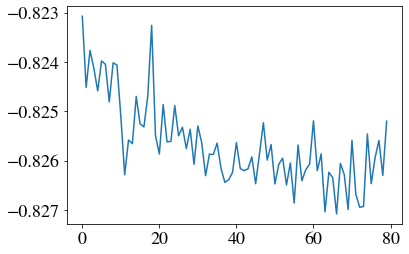

In [161]:
plt.plot(losses[20:])
#plt.yscale("log")

## Save

In [162]:
trained_model = edict()
trained_model.model = rnn
trained_model.loss_fn = loss_fn
trained_model.optimizer = optimizer
trained_model.paras = paras_rnn
trained_model.loss = losses
save_pkl_dict2folder(RES_ROOT/f"LSTM_simu_net_{data_idx}", trained_model, is_force=False)

/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_1
Create a folder /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_1
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_1/model.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_1/loss_fn.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_1/optimizer.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_1/paras.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_1/loss.pkl


## Evaluate

In [163]:
X_test = random_samples_rnn(cur_data,
                            bds=[[0], [360]],
                            theta2raw_fn=None)
rnn.eval()
with torch.no_grad():
    Y_pred = rnn(X_test).squeeze()

In [164]:
std_fn = lambda x: (x-x.mean(axis=-1, keepdims=True))/x.std(axis=-1, keepdims=True)

In [165]:
sgm_net.eval()
with torch.no_grad():
    X_rec1 = sgm_net(Y_pred)
X_rec1 = X_rec1.numpy()
#X_rec1 = std_fn(X_rec1)

X_org = std_fn(cur_data)

In [166]:
sgmmodel = SGM(paras.C, paras.D, paras.freqs)
X_rec2 = []
for sgm_params_cur in tqdm(Y_pred):
    cur_PSD = sgmmodel.run_local_coupling_forward(sgm_params_cur.numpy())
    X_rec2.append(cur_PSD[:68])
X_rec2 = np.array(X_rec2)
#X_rec2 = std_fn(X_rec2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [02:03<00:00,  2.92it/s]


In [167]:
def ana_corr(data_org, data_rec):
    corrs_psd = []
    for ix in range(data_org.shape[0]):
        seq_x = data_org[ix]
        seq_y = data_rec[ix]
        res = scipy.stats.pearsonr(seq_x, seq_y)
        corrs_psd.append(res[0])
        
        
    data_org_std = std_mat(data_org)
    data_rec_std = std_mat(data_rec)
    corr_psd_uni = scipy.stats.pearsonr(
        data_org_std.mean(axis=0), 
        data_rec_std.mean(axis=0))[0]
    
    corrs_sp = []
    for ix in range(data_org.shape[1]):
        seq_x = data_org[:, ix]
        seq_y = data_rec[:, ix]
        res = scipy.stats.pearsonr(seq_x, seq_y)
        corrs_sp.append(res[0])
    return corr_psd_uni, corrs_psd, corrs_sp

In [168]:
corrs1 = []
corrs2 = []
corrs1_roiwise = []
corrs2_roiwise = []
for ix in range(len(X_org)):
    res1 =ana_corr(X_org[ix], X_rec1[ix])
    res2 =ana_corr(X_org[ix], X_rec2[ix])
    
    corrs1.append(res1[0])
    corrs1_roiwise.append(np.mean(res1[1]))
    corrs2.append(res2[0])
    corrs2_roiwise.append(np.mean(res2[1]))
print(np.mean(corrs1), np.std(corrs1))
print(np.mean(corrs2), np.std(corrs2))
print(np.mean(corrs1_roiwise), np.std(corrs1_roiwise))
print(np.mean(corrs2_roiwise), np.std(corrs2_roiwise))

0.9769436241833388 0.01075510879788169
0.9076652246435144 0.024634862901308906
0.8230439955485414 0.026624683972898064
0.7635136009219716 0.03085106503999986


In [169]:
print(np.stack([
    np.argsort(corrs1)[:10],
    np.argsort(corrs2)[:10]]))

print(np.stack([
    np.argsort(-np.array(corrs1))[:10],
    np.argsort(-np.array(corrs2))[:10]]))

[[228 289 229 288 183 227 290 103 102 182]
 [147 146 231 101 342 209 210 262 265 264]]
[[172 130 173  36 131 153 128  31  37  30]
 [154 153 155 152 151  40  90 319 320  91]]


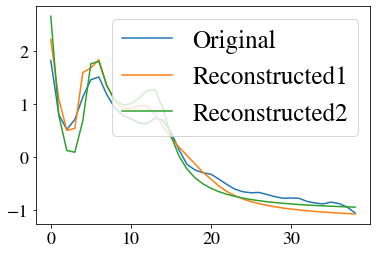

In [170]:
idx = np.argmin(corrs1)
idx = 154
plt.plot(std_mat(X_org[idx]).mean(axis=0), label="Original")
plt.plot(std_mat(X_rec1[idx]).mean(axis=0), label="Reconstructed1")
plt.plot(std_mat(X_rec2[idx]).mean(axis=0), label="Reconstructed2")
plt.legend()

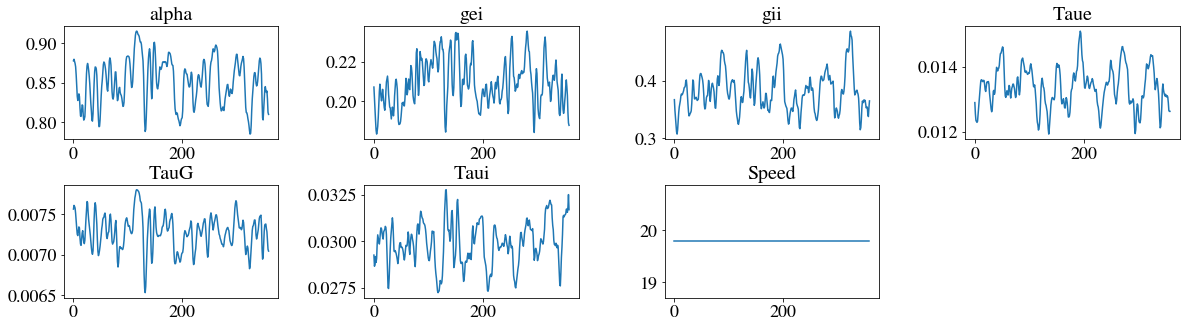

In [171]:
plt.figure(figsize=[20, 5])
for ix in range(7):
    plt.subplot(2, 4, ix+1)
    plt.plot(Y_pred.numpy()[:, ix])
    plt.title(paras.names[ix], fontsize=20)

(0.0, 550.0)

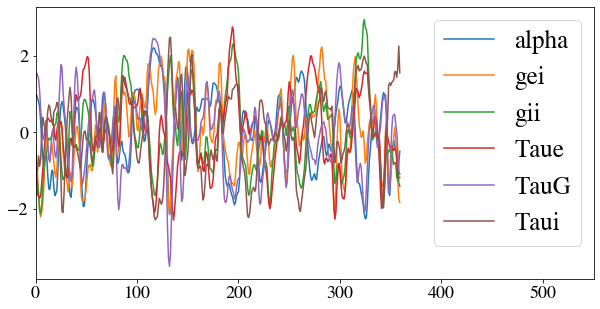

In [172]:
plt.figure(figsize=[10, 5])
for ix in range(6):
    plt.plot(std_vec(Y_pred.numpy()[:, ix]), label=paras.names[ix])
plt.legend()
plt.xlim(0, 550)

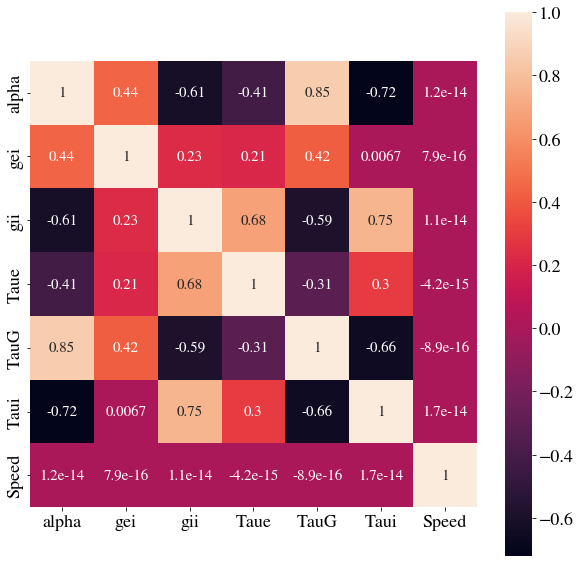

In [175]:
plt.figure(figsize=[10, 10])
sns.heatmap(np.corrcoef(Y_pred.numpy().T), square=True, annot=True, 
            annot_kws=dict(fontsize=15))
plt.xticks(np.arange(7)+0.5, paras.names)
plt.yticks(np.arange(7)+0.5, paras.names);